## read in data

In [1]:
# data
import pandas as pd
import numpy as np
df = pd.read_parquet('./material/pairs_lucas_plausible.pq')
print('original pairs', df.shape)

original pairs (30612, 21)


## assign its corrsponding covariates

In [2]:
cdf = pd.read_parquet('./material/soc.snr.series_overlaid_v20250301.pq')
drop_col = ['ndvi_slope', 'ndwi_slope', 'ndvi_p50_mean', 'ndwi_p50_mean', 'lat_series','lon_series', 'time_series', 'soc_series', 'c/n_series','lc_survey_series', 'ndvi_p50_series','ndwi_p50_series',
            'trend_class','fluctuation', 'lc_change', 'lc', 'distance', 'plausible', 'cn_std','ts_slope', 'ts_intercept', 'ts_score', 'linear_ts', 'dist_max','lat','lon']
cdf = cdf.drop(columns=drop_col)

odf = df.merge(cdf, how='left', on = ['id','ref','nuts0'])
print(odf.shape)

(30612, 2290)


## examine the overlaid features

In [3]:
crop_col = []
for ii in odf.columns:
    if 'cropland' in ii:
        odf.loc[odf[ii].isna(),ii] = 0
        odf.loc[odf[ii]>0,ii] = 100
        crop_col.append(ii)

In [4]:
# remove less relevant feature
drop_col = []

for ii in odf.columns:
    if 'evi' in ii:
        drop_col.append(ii)
    if 'nos' in ii:
        drop_col.append(ii)
    if 'cdr' in ii:
        drop_col.append(ii)
    if 'backscatter' in ii:
        drop_col.append(ii)
    if 'palsar' in ii:
        drop_col.append(ii)
        
odf = odf.drop(columns=drop_col)

In [5]:
with open('./material/static_covar.txt', 'r') as file:
    sta = file.readlines()
    
sta = [ii.strip().split('/')[-1][0:-4] for ii in sta]

# static columns
scol = []
for ii in sta:
    if '{perc}' in ii:
        if 'glad' in ii:
            for perc in ['p25','p50','p75']:
                scol.append(ii.replace('{perc}',perc))
        elif 'moisture' in ii:
            for perc in ['p0.05','p0.5','p0.95']:
                scol.append(ii.replace('{perc}',perc))
        elif 'CHELSA' in ii:
            for perc in ['min','max','range','mean']:
                scol.append(ii.replace('{perc}',perc))
    else:
        if ii not in drop_col:
            scol.append(ii)
        
# temporal columns        
tcol = []
for ii in odf.columns[21:]:
    if ii not in scol:
        if ii not in ['lon', 'lat', 'start_idx', 'end_idx']:
            if ii not in drop_col:
                tcol.append(ii)
            
for ii in tcol+scol:
    m = odf[ii].isna().sum()
    if m > 50:
        print(ii,m)


non.photosynthetic.veg_mcd43a4.fc_m_500m_s_20000101_20001231_go_epsg.4326_v20240616 54
non.photosynthetic.veg_mcd43a4.fc_std_500m_s_20000101_20001231_go_epsg.4326_v20240616 63
non.photosynthetic.veg_mcd43a4.fc_m_500m_s_20010101_20011231_go_epsg.4326_v20240616 54
non.photosynthetic.veg_mcd43a4.fc_std_500m_s_20010101_20011231_go_epsg.4326_v20240616 63
non.photosynthetic.veg_mcd43a4.fc_std_500m_s_20020101_20021231_go_epsg.4326_v20240616 54
non.photosynthetic.veg_mcd43a4.fc_mx_500m_s_20020101_20021231_go_epsg.4326_v20240616 51
non.photosynthetic.veg_mcd43a4.fc_m_500m_s_20020101_20021231_go_epsg.4326_v20240616 51
non.photosynthetic.veg_mcd43a4.fc_std_500m_s_20050101_20051231_go_epsg.4326_v20240616 54
bare.soil_mcd43a4.fc_std_500m_s_20070101_20071231_go_epsg.4326_v20240616 51
non.photosynthetic.veg_mcd43a4.fc_std_500m_s_20070101_20071231_go_epsg.4326_v20240616 57
bare.soil_mcd43a4.fc_std_500m_s_20100101_20101231_go_epsg.4326_v20240616 51
bare.soil_mcd43a4.fc_std_500m_s_20110101_20111231_go_e

## feature engineer to reflect temporal process

In [6]:
from skmap.misc import find_files, GoogleSheet, ttprint
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

def extract_time_series_features(ts):
    ts = np.array(ts)
    time = np.arange(len(ts))
    
    mean_val = np.mean(ts)
    std_val = np.std(ts)
    slope, _, _, _, _ = linregress(time, ts)
    autocorr_lag1 = np.corrcoef(ts[:-1], ts[1:])[0, 1] if len(ts) > 1 else np.nan
    
    return mean_val, std_val, slope, autocorr_lag1

odf['start_idx'] = odf['time_pair'].apply(lambda x: int(x[0]) - 2000)
odf['end_idx'] = odf['time_pair'].apply(lambda x: int(x[-1]) - 2000 + 1)



In [7]:
ttcol = [ii for ii in tcol if '_2000' in ii]
ttprint('start')
for it in ttcol:
    extract_cols = [it.replace('_2000', f'_{ival}') for ival in np.arange(2000,2024,1)]
        
    extract_cols = [col for col in extract_cols if col in odf.columns]

    odf['ts'] = odf[extract_cols].apply(lambda x: x.values.astype(float).tolist(), axis=1)

    # Now slice the time series into pre and during, row-wise
    odf['pre_ts'] = odf.apply(lambda row: row['ts'][:row['start_idx']], axis=1)
    odf['during_ts'] = odf.apply(lambda row: row['ts'][row['start_idx']:row['end_idx']], axis=1)
    odf['full_ts'] = odf.apply(lambda row: row['ts'][:row['end_idx']], axis=1)

    # Feature extraction using apply
    odf[[f'{it}_pre_mean', f'{it}_pre_std', f'{it}_pre_slope', f'{it}_pre_lag1']] = odf['pre_ts'].apply(
        lambda x: pd.Series(extract_time_series_features(x))
    )

    odf[[f'{it}_during_mean', f'{it}_during_std', f'{it}_during_slope', f'{it}_during_lag1']] = odf['during_ts'].apply(
        lambda x: pd.Series(extract_time_series_features(x))
    )

    odf[[f'{it}_full_mean', f'{it}_full_std', f'{it}_full_slope', f'{it}_full_lag1']] = odf['full_ts'].apply(
        lambda x: pd.Series(extract_time_series_features(x))
    )

    odf.drop(columns=extract_cols + ['pre_ts', 'during_ts', 'full_ts', 'ts'], inplace=True)

ttprint('finish')

odf = odf.drop(columns=['start_idx','end_idx'])
print(odf.shape)
odf.to_parquet('./material/pair_feature.engineered.pq')

[14:02:46] start
[14:53:53] finish
(30612, 1216)


## mend missing files

In [8]:
import pandas as pd
df = pd.read_parquet('./material/pair_feature.engineered.pq')
acol = df.columns[21:].values.tolist()
print(df.shape)

(30612, 1216)


In [9]:
# drop all lag columsn
drop_col = [ii for ii in df.columns if '_lag1' in ii]
df = df.drop(columns=drop_col)
print(df.shape)

# drop all cols with invalid value > 50
acol = [ii for ii in acol if ii not in drop_col]
drop_col = []
for ii in acol:
    m = df[ii].isna().sum()
    if m > 150:
        drop_col.append(ii)
        print(ii, m)
        
df = df.drop(columns=drop_col)
print(df.shape)

(30612, 997)
b6_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b12_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b4_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b7_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b5_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
CHELSA_swe_1981-2010_V.2.1 17103
b8a_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b2_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b3_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b11_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
b8_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 17736
(30612, 986)


In [10]:
# check other columns with missing values, fill with mean
drop_col = []
acol = df.columns[21:].values.tolist()
df[acol] = df[acol].fillna(df[acol].mean(numeric_only=True))

for ii in acol:
    m = df[ii].isna().sum()
    if m > 0:
        # print(ii, m)
        drop_col.append(ii)
        
print(df.shape)

(30612, 986)


## assign tile id

In [19]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
eu_tile = gpd.read_file('/home/xuemeng/work_xuemeng/soc/data/000_tiles.correct_epsg.3035.gpkg')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_mean_x, df.lon_mean_x))
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(eu_tile.crs)

joined_gdf = gpd.sjoin(gdf, eu_tile, how="left", op='within')
joined_gdf = joined_gdf.drop(columns=['geometry','index_right','lon_mean_y','lat_mean_y'])
joined_gdf = joined_gdf.rename(columns={'id_right':'tile_id','id_left':'id'})
df = joined_gdf
print(df.shape)

(30612, 985)


## split the train test set

In [20]:
ttid = pd.read_csv('./material/test_temporal_ids_v20250301.txt', header=None)[0].tolist() 
print(len(ttid))
ttid = [str(i) for i in ttid]

1000


In [21]:
test = df.loc[df['id'].isin(ttid)]
print(test.shape)
test.to_parquet('./material/data.pair_test_v20250301.pq')
other = df.loc[~df['id'].isin(ttid)]
cal = other.sample(1000, random_state=42)
cal.to_parquet('./material/data.pair_cal_v20250301.pq')
print(cal.shape)
train = other.drop(cal.index)
print(train.shape)
train.to_parquet('./material/data.pair_train_v20250301.pq')

(3000, 985)
(1000, 985)
(26612, 985)


## check distribution

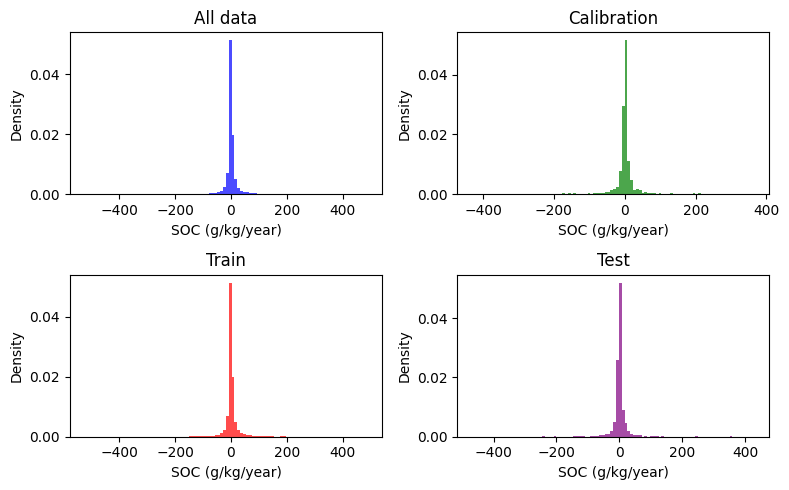

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(df["soc_change"], bins=100, alpha=0.7, color="blue", density=True)
axes[0, 0].set_title("All data")
axes[0, 0].set_xlabel("SOC (g/kg/year)")
axes[0, 0].set_ylabel("Density")

axes[0, 1].hist(cal["soc_change"], bins=100, alpha=0.7, color="green", density=True)
axes[0, 1].set_title("Calibration")
axes[0, 1].set_xlabel("SOC (g/kg/year)")
axes[0, 1].set_ylabel("Density")

axes[1, 0].hist(train["soc_change"], bins=100, alpha=0.7, color="red", density=True)
axes[1, 0].set_title("Train")
axes[1, 0].set_xlabel("SOC (g/kg/year)")
axes[1, 0].set_ylabel("Density")

axes[1, 1].hist(test["soc_change"], bins=100, alpha=0.7, color="purple", density=True)
axes[1, 1].set_title("Test")
axes[1, 1].set_xlabel("SOC (g/kg/year)")
axes[1, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()